# Analysis of various PD Datasets

In [ ]:
#!pip install xgboost
#!pip install GaussianNB

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

import xgboost as xgb
#from glmnet import LogitNet
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
path="/Users/michaelallwright/Dropbox (Sydney Uni)/michael_PhD/Projects/PPMI/Data/"
pdbp="/Users/michaelallwright/Documents/python/PDBP/Project Final/data/"

In [ ]:
#from PDBPfunctions import *
def train_test(df,var,split=0.7):
    train=df.sample(round(df.shape[0]*split))
    test=df[~(df[var].isin(train['Sample']))]
    #print(train.shape)
    #print(test.shape)
    return train,test

def return_accuracy(X_train1,y_train1,X_test1,y_test1,model):
    model.fit(X_train1,y_train1)
    preds=model.predict(X_test1)
    probs=model.predict_proba(X_test1)[:, 1]
    acc_score=np.mean(preds==y_test1)
    
    y_vals=np.where(y_test1=="PD", 1, 0)
    auc_score=roc_auc_score(y_vals, probs)
    return acc_score,auc_score


def model(df,model,yvar):
    X=np.asarray(df.drop(['Unnamed: 0','Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
    y=np.asarray(df[yvar])

    train,test=train_test(df,'Sample',0.7)

    X_train=np.asarray(train.drop(["Unnamed: 0",'Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
    y_train=np.asarray(train[yvar])
    
    print(X_train)

    X_test=np.asarray(test.drop(["Unnamed: 0",'Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
    y_test=np.asarray(test[yvar])

    model_obj=model.fit(X_train,y_train)
    preds=model_obj.predict(X_test)
    test=test.drop(["Unnamed: 0"],axis=1)
    test['Diag_pred']=preds.tolist()
    
    acc_score=np.mean(preds==y_test)
    
    print(acc_score)
    
    if yvar=="Diagnosis":
        probs=model_obj.predict_proba(X_test)[:, 1]
        y_vals=np.where(y_test=="PD", 1, 0)
        auc_score=roc_auc_score(y_vals, probs)
        print(auc_score)
        test['Diag_prob']=probs.tolist()
        
    else:
        auc_score=0

    return test,acc_score,auc_score

def model2(df,model,remcols,yvar,yname,diffexp=0,numgenes=1000):
    #X=np.asarray(df.drop(remcols,axis=1))
    #y=np.asarray(df[yvar])

    train,test=train_test(df,'Sample',0.7)
    
    if diffex==1:
        train=train[np.append(diffex(train,numgenes),yvar)]
        test=test[np.append(diffex(train,numgenes),yvar)]
    
    else:
        train=train.drop(['Sample'],axis=1)
        test=test.drop(['Sample'],axis=1)
    #train=diffex(mod_dataPDBP,100)
    #sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
    #np.asarray(X)

    X_train=np.asarray(train.drop(remcols,axis=1))
    y_train=np.asarray(train[yvar])
    

    X_test=np.asarray(test.drop(remcols,axis=1))
    y_test=np.asarray(test[yvar])
    
    

    model_obj=model.fit(X_train,y_train)
    preds=model_obj.predict(X_test)
    
  
    test['Diag_pred']=preds.tolist()
    
    acc_score=np.mean(preds==y_test)
    
    #print(acc_score)
    
    #if yvar=="Diagnosis":
    probs=model_obj.predict_proba(X_test)[:, 1]
    #print(y_test)
    y_vals=np.where(y_test==yname, 1, 0)
    auc_score=roc_auc_score(y_vals, probs)
    test['Diag_prob']=probs.tolist()
        
   # else:
   #     auc_score=0
        
    #print(auc_score)

    return test,acc_score,auc_score

def rebalance(df,yvar,hcvar,pdvar):
    data_mod_HC=df[(df[yvar]==hcvar)]
    data_mod_PD=df[(df[yvar]==pdvar)]
    datasize=min(data_mod_HC.shape[0],data_mod_PD.shape[0])
    data_mod_PD=pd.DataFrame(data_mod_PD.sample(datasize))
    data_mod_HC=pd.DataFrame(data_mod_HC.sample(datasize))
    data_mod=pd.concat([data_mod_HC,data_mod_PD],axis=0)
    return data_mod

In [ ]:
def diffex(df,n=1000):
    df_Xpdbp=df
    #df_Xpdbp=df.drop(['Sample'],axis=1)
    dfnew=pd.DataFrame(df_Xpdbp.groupby('Diagnosis').mean()).reset_index()
    dfnew=pd.DataFrame(dfnew.transpose())
    dfnew.columns=['PD','HC']
    dfnew['Gene']=dfnew.index
    dfnew=dfnew[(dfnew['Gene']!="Diagnosis")]
    dfnew['diff']=abs(dfnew['PD']-dfnew['HC'])
    dfnew=dfnew.sort_values(by='diff',ascending=False)
    dfnew=dfnew.head(n)
    cols=dfnew['Gene'].unique()
    return cols   

In [ ]:
def resamplemodel(df,reps=10,yvars="Diagnosis",ynm="PD",model=svc_mod,diff=0,numgn=1000):
    acc_arr=np.asarray([])
    auc_arr=np.asarray([])
    for i in range(reps):
        test,accuracy,auc_score=model2(df,model,remcols,yvar=yvars,yname=ynm,diffexp=diff,numgenes=numgn)
        acc_arr=np.append(acc_arr,accuracy)
        auc_arr=np.append(auc_arr,auc_score)
    acc_score_df=pd.DataFrame({"accuracy":acc_arr,"auc":auc_arr})
    ax = sns.boxplot(x=acc_score_df["auc"])
    plt.show()
    
    print(acc_score_df["auc"].mean())
    return acc_score_df

def resamplemodel_mult(df,reps=10,yvar="Diagnosis",ynm="PD",model=svc_mod,diff=0,numgn=1000):
    mod_arr=np.asarray([])
    acc_arr=np.asarray([])
    auc_arr=np.asarray([])
    for i in range(reps):
        for j,mod in enumerate(classifiers):
            test,accuracy,auc_score=model2(df,mod,yvar,remcols,yname=ynm,diffexp=diff,numgenes=numgn)
            acc_arr=np.append(acc_arr,accuracy)
            auc_arr=np.append(auc_arr,auc_score)
            mod_arr=np.append(mod_arr,names[j])
    acc_score_df=pd.DataFrame({"model":mod_arr,"accuracy":acc_arr,"auc":auc_arr})
    
    ax = sns.boxplot(x="Model",y="auc", data=acc_score_df)
    ax = sns.swarmplot(x="Model",y="auc", data=acc_score_df, color=".25")
    plt.show()
    
    print(acc_score_df["auc"].mean())
    return acc_score_df

In [ ]:
xgb_gs3=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
           max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
           n_estimators=60, n_jobs=1, nthread=4, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
           seed=42, silent=None, subsample=1, verbosity=1)

svc_mod=SVC(kernel="linear", C=0.025,probability=True)
rfor=RandomForestClassifier(n_estimators=100)
nb=GaussianNB()

In [9]:
remcols=['Diagnosis']

define models and corresponding names

In [12]:
names=['svm','random forest',"Naive Bayes"]
models=[SVC(kernel="linear", C=0.025,probability=True),RandomForestClassifier(n_estimators=100),GaussianNB()]

#### Data Imports 

In [14]:
%%time
PPMImod_fin=pd.read_csv('%s%s' % (path,'PPMImod_fin.csv'))

CPU times: user 5min 12s, sys: 7.91 s, total: 5min 20s
Wall time: 5min 21s


In [15]:
PPMImod_fin2=PPMImod_fin.drop(['Unnamed: 0'],axis=1)

In [16]:
geodata=pd.read_csv('%s%s' % (pdbp,'mod_data_geo.csv'))

In [17]:
mod_dataPDBP=pd.read_csv('%s%s' % (pdbp,'mod_dataPDBP.csv'))

In [18]:
mod_dataPDBPv2=pd.read_csv('%s%s' % (pdbp,'mod_dataPDBPv2.csv'))

#### Data Processing for models

In [19]:
data_mod=rebalance(PPMImod_fin[(PPMImod_fin['RECRUITMENT_CAT']=="HC")|
                              (PPMImod_fin['RECRUITMENT_CAT']=="PD")],"RECRUITMENT_CAT","PD","HC")
data_mod=data_mod.drop(['RECRUITMENT_CAT'],axis=1)

In [20]:
mod_dataBF=pd.read_csv('%s%s' % (pdbp,"BF_data_t.csv"))

In [21]:
mod_dataBF.rename(columns={'diagnosis':'Diagnosis'},inplace=True) 

In [22]:
mod_dataPDBP.rename(columns={'sample':'Sample'}, inplace=True)
mod_dataPDBPv2.rename(columns={'sample':'Sample'}, inplace=True)

#### PDBP Data Longitudinal Examination

In [23]:
mod_dataPDBPSetA=mod_dataPDBPv2[(mod_dataPDBPv2['Sample.Set']=="A")].drop(['Sample.Set'],axis=1)
mod_dataPDBPSetAmod=mod_dataPDBPSetA.drop(['SubjectID'],axis=1)
mod_dataPDBPSetB=mod_dataPDBPv2[(mod_dataPDBPv2['Sample.Set']=="B")].drop(['Sample.Set'],axis=1)
mod_dataPDBPSetBmod=mod_dataPDBPSetB.drop(['SubjectID'],axis=1)

In [24]:
mod_dataPDBPSetAmod2=mod_dataPDBPSetAmod
mod_dataPDBPSetAmod2['Set']="A"
mod_dataPDBPSetBmod2=mod_dataPDBPSetBmod
mod_dataPDBPSetBmod2['Set']="B"
mod_dataPDBPlong=pd.concat([mod_dataPDBPSetAmod2,mod_dataPDBPSetBmod2],axis=0)

In [25]:
mod_dataPDBPlongPDHC=mod_dataPDBPlong[(mod_dataPDBPlong['Diagnosis'].isin(["PD","HC"]))]

In [26]:
sampsum=pd.DataFrame(mod_dataPDBPlongPDHC.groupby('Sample').sum()).reset_index()

In [27]:
sampsum=pd.melt(sampsum,id_vars="Sample")

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = sns.boxplot(x="Sample",y="value", data=sampsum)
ax = sns.swarmplot(x="Sample",y="value", data=sampsum, color=".25")

In [ ]:
Abydiag=pd.DataFrame(mod_dataPDBPSetA[(mod_dataPDBPSetA['Diagnosis'].isin(["HC","PD"]))].drop(['SubjectID','Sample'],axis=1).groupby("Diagnosis").mean()).reset_index().transpose()
Abydiag.columns=["HC_A","PD_A"]
Abydiag=Abydiag[(Abydiag["HC_A"]!="HC")]
Abydiag['transcript']=Abydiag.index

Bbydiag=pd.DataFrame(mod_dataPDBPSetB[(mod_dataPDBPSetB['Diagnosis'].isin(["HC","PD"]))].drop(['SubjectID','Sample'],axis=1).groupby("Diagnosis").mean()).reset_index().transpose()
Bbydiag.columns=["HC_B","PD_B"]
Bbydiag=Bbydiag[(Bbydiag["HC_B"]!="HC")]
Bbydiag['transcript']=Bbydiag.index
Bbydiag
Diagtime=pd.merge(Bbydiag,Abydiag,on="transcript")

In [ ]:
Diagtime['DiffHC']=Diagtime.apply(lambda x:(x["HC_A"]-x['HC_B'])**2,axis=1)/Diagtime.apply(lambda x:(x["HC_A"]-x['HC_B'])**2,axis=1).sum()
Diagtime['DiffPD']=Diagtime.apply(lambda x:(x["PD_A"]-x['PD_B'])**2,axis=1)/Diagtime.apply(lambda x:(x["PD_A"]-x['PD_B'])**2,axis=1).sum()
Diagtime['DiffA']=Diagtime.apply(lambda x:(x["PD_A"]-x['HC_A'])**2,axis=1)/Diagtime.apply(lambda x:(x["PD_A"]-x['HC_A'])**2,axis=1).sum()
Diagtime['DiffB']=Diagtime.apply(lambda x:(x["PD_B"]-x['HC_B'])**2,axis=1)/Diagtime.apply(lambda x:(x["PD_B"]-x['HC_B'])**2,axis=1).sum()

In [ ]:
print(Diagtime.apply(lambda x:(x["PD_A"]-x['PD_B'])**2,axis=1).sum())
print(Diagtime.apply(lambda x:(x["HC_A"]-x['HC_B'])**2,axis=1).sum())

Are the transcripts that are different roughly the same? Determine this by sorting both in order of max difference and then determining the change in position

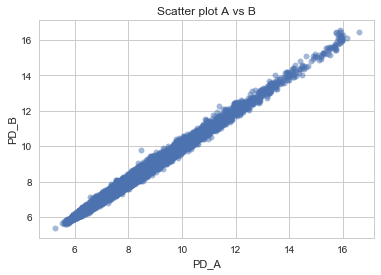

In [158]:
plt.scatter(Diagtime['PD_A'], Diagtime['PD_B'], s=30, alpha=0.5)
plt.title('Scatter plot A vs B')
plt.xlabel('PD_A')
plt.ylabel('PD_B')
plt.show()

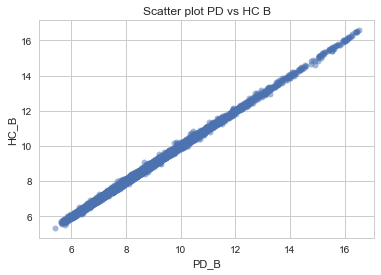

In [160]:
plt.scatter(Diagtime['PD_B'], Diagtime['HC_B'], s=30, alpha=0.5)
plt.title('Scatter plot PD vs HC B')
plt.xlabel('PD_B')
plt.ylabel('HC_B')
plt.show()

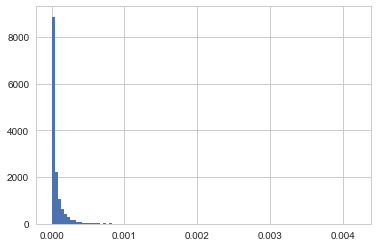

In [26]:
%matplotlib inline
Diagtime['DiffB'].hist(bins=100)

In [27]:
print(np.mean(Diagtime["HC_B"]-Diagtime["PD_B"]))
print(np.mean(Diagtime["HC_A"]-Diagtime["PD_A"]))
print(np.mean(Diagtime["HC_A"]-Diagtime["HC_B"]))

-0.00032784887054530825
-0.0006863309325112344
-0.00030682824619330574


#### Check intersection of BF and PDBP

In [28]:
#intersection BF and PDBP
interseccols=np.intersect1d(mod_dataPDBP.columns, mod_dataBF.columns, assume_unique=False)
mod_dataBF_int=mod_dataBF[interseccols]
mod_dataPDBP_int=mod_dataPDBP[interseccols]

In [29]:
mod_dataPDBP=rebalance(mod_dataPDBP,'Diagnosis',"HC","PD")

#### Geodata Manipulation

In [ ]:
geodata['Diagnosis'][(geodata['Diagnosis']=="IPD")]="PD"
geodata['Diagnosis'][(geodata['Diagnosis']=="CONTROL")]="HC"
geodata=geodata.drop(['Unnamed: 0'],axis=1)
geodata=rebalance(geodata[(geodata['Diagnosis']=="HC")|
                              (geodata['Diagnosis']=="PD")],"Diagnosis","PD","HC")
print(geodata['Diagnosis'].value_counts())

#### Run Models

In [495]:
remcols=['Diagnosis']

In [ ]:
%%time
acc_score_df_geo=resamplemodel(geodata,reps=10,yvar="Diagnosis",ynm="PD",model=svc_mod,diff=0)

In [ ]:
%%time
resamplemodel_mult(geodata,reps=10,yvar="Diagnosis",ynm="PD",model=svc_mod,diff=0)

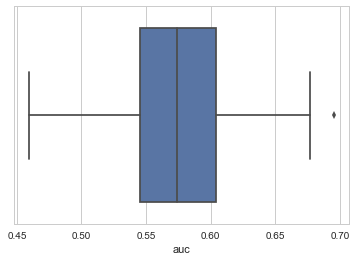

0.5763376536885556
CPU times: user 1min 18s, sys: 25 s, total: 1min 43s
Wall time: 1min 45s


In [ ]:
%%time
acc_score_df_geo=resamplemodel(geodata,reps=100,model=nb,diff=0)

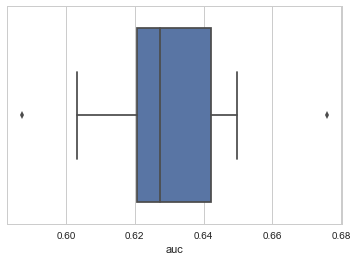

0.6294461652794936
CPU times: user 22.6 s, sys: 1.09 s, total: 23.7 s
Wall time: 24.1 s


In [330]:
%%time
acc_score_df_geo=resamplemodel(geodata,reps=10,model=rfor,diff=0)

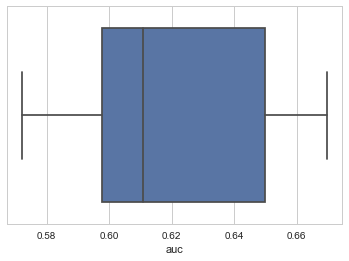

0.6191712629653512


In [308]:
%%time
acc_score_ppmi=resamplemodel(data_mod,reps=10,model=svc_mod,diff=0)

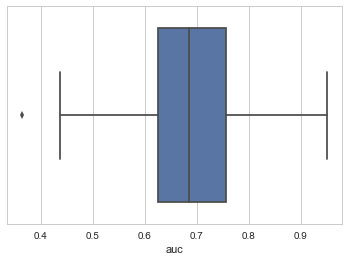

0.6868324904262405


In [111]:
acc_score_df_bf=resamplemodel(mod_dataBF_int,reps=100,model=nb,diff=0,numgn=mod_dataBF_int.shape[1]-3)

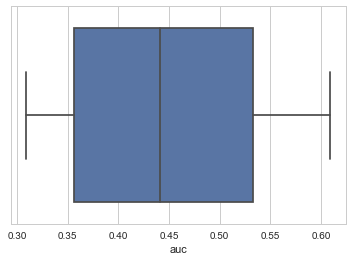

0.45030393217893216


In [237]:
acc_score_df_bf=resamplemodel(mod_dataBF,reps=10,model=svc_mod,numgn=mod_dataBF.shape[1]-3)

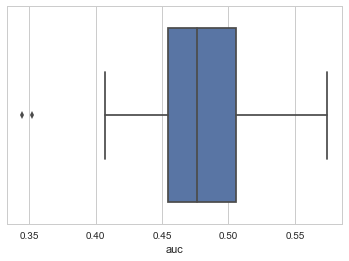

0.4767806668420366


In [110]:
acc_score_df_pdbp_nb=resamplemodel(mod_dataPDBP,reps=100,model=nb,numgn=mod_dataPDBP.shape[1]-3)

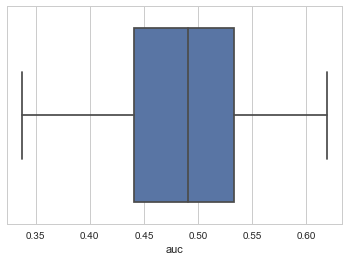

0.4899795633582602


In [339]:
acc_score_df_pdbp_rf=resamplemodel(mod_dataPDBP,reps=100,model=rfor,diff=0)

In [113]:
mod_dataPDBPSetAmod2=mod_dataPDBPSetAmod[(mod_dataPDBPSetAmod['Diagnosis']=="PD")|
                                                       (mod_dataPDBPSetAmod['Diagnosis']=="HC")]

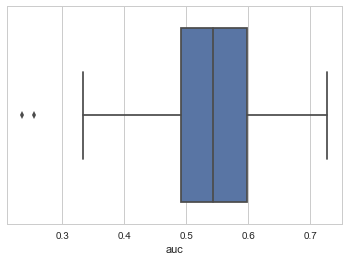

0.538344426125665
CPU times: user 1min 11s, sys: 1.94 s, total: 1min 13s
Wall time: 1min 17s


In [114]:
%%time
acc_score_df_pdbp_int=resamplemodel(mod_dataPDBPSetAmod2.drop(columns="Set"),reps=100,model=svc_mod,diff=0)

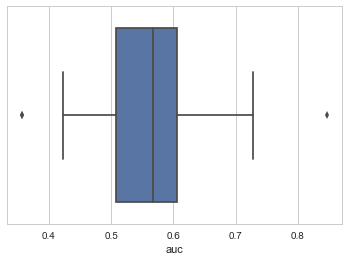

0.5563157866268994


In [36]:
acc_score_df_pdbp_int=resamplemodel(mod_dataPDBPSetBmod,reps=100,model=svc_mod,diff=0)

Longitudinal

In [377]:
remcols=['Sample.Set']

In [380]:
mod_data_PDBPlong['Sample.Set'].value_counts()

B    58
A    57
Name: Sample.Set, dtype: int64

In [74]:
df=mod_dataPDBPlongPDHC.drop(columns="Diagnosis",axis=0)

In [150]:
mod_dataPDBPlongPD=mod_dataPDBPlongPDHC[(mod_dataPDBPlongPDHC['Diagnosis']=="PD")]
mod_dataPDBPlongHC=mod_dataPDBPlongPDHC[(mod_dataPDBPlongPDHC['Diagnosis']=="HC")]

In [153]:
mod_dataPDBPlongPDHC.columns

Index(['Sample', 'GE_BrightCorner', 'DarkCorner',
       'gi|557786191|ref|NM_001286644.1|', 'A_37_P161620', 'A_33_P3309662',
       'gi|566006137|ref|NM_014447.3|', 'A_23_P16143', 'A_37_P032057',
       'gi|48928055|ref|NM_006948.4|',
       ...
       'gi|182519230|ref|NM_002211.3|', 'A_23_P167595',
       'gi|62177109|ref|NM_032804.5|', 'CUST_380_PI432175857',
       'ENST00000609401.5', 'A_37_P128675', 'ENST00000563158.1',
       'A_23_P137814', 'Diagnosis', 'Set'],
      dtype='object', length=14323)

In [140]:
remcols=['Diagnosis','Set']

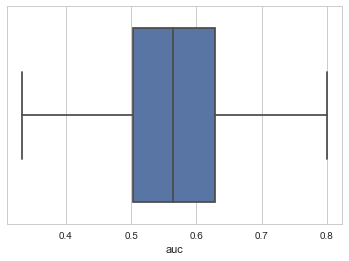

0.5571481136695797
CPU times: user 1min 9s, sys: 1.68 s, total: 1min 11s
Wall time: 1min 13s


In [156]:
%%time
acc_score_df_pdbpdiag=resamplemodel(mod_dataPDBPlongPDHC[(mod_dataPDBPlongPDHC['Set']=="A")],yvars='Diagnosis',ynm="PD",reps=100,model=svc_mod,diff=0)

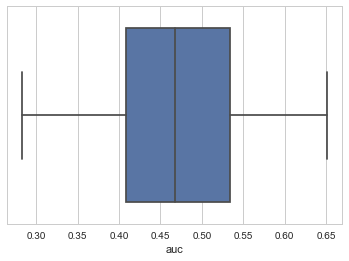

0.4667913794989839
CPU times: user 1min 8s, sys: 1.6 s, total: 1min 9s
Wall time: 1min 11s


In [157]:
%%time
acc_score_df_pdbpdiag=resamplemodel(mod_dataPDBPlongPDHC[(mod_dataPDBPlongPDHC['Set']=="B")],yvars='Diagnosis',ynm="PD",reps=100,model=svc_mod,diff=0)

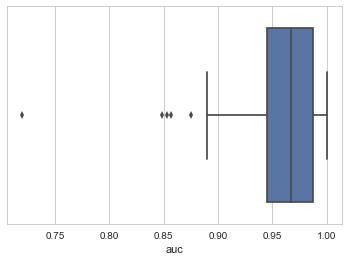

0.9581766824478122
CPU times: user 56 s, sys: 1.41 s, total: 57.4 s
Wall time: 59.4 s


In [151]:
%%time
acc_score_df_pdbplong=resamplemodel(mod_dataPDBPlongHC,yvars='Set',ynm="B",reps=100,model=svc_mod,diff=0)

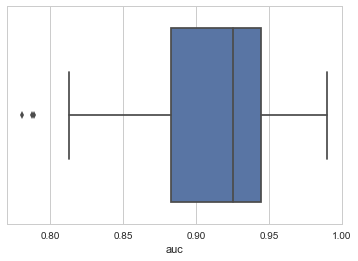

0.9132019098927916
CPU times: user 1min 6s, sys: 1.26 s, total: 1min 7s
Wall time: 1min 9s


In [148]:
%%time
acc_score_df_pdbplong=resamplemodel(mod_dataPDBPlongPD,yvars='Set',ynm="B",reps=100,model=svc_mod,diff=0)

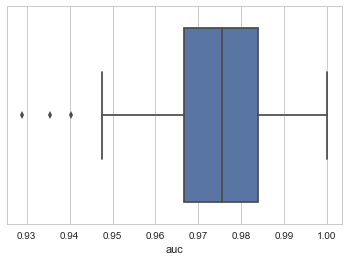

0.9746613969708565
CPU times: user 3min 24s, sys: 3.26 s, total: 3min 27s
Wall time: 3min 32s


In [149]:
%%time
acc_score_df_pdbplong=resamplemodel(mod_dataPDBPlongPDHC,yvars='Set',ynm="B",reps=100,model=svc_mod,diff=0)

In [116]:
mod_dataPDBPlongPDHC

,Sample,GE_BrightCorner,DarkCorner,gi|557786191|ref|NM_001286644.1|,A_37_P161620,A_33_P3309662,gi|566006137|ref|NM_014447.3|,A_23_P16143,A_37_P032057,gi|48928055|ref|NM_006948.4|,...,gi|182519230|ref|NM_002211.3|,A_23_P167595,gi|62177109|ref|NM_032804.5|,CUST_380_PI432175857,ENST00000609401.5,A_37_P128675,ENST00000563158.1,A_23_P137814,Diagnosis,Set
41,US80603148_258567810006_S01_GE1_1200_Jun14_1_2,16.889702,5.848927,10.005292,6.440988,10.093173,8.551487,9.025186,6.613493,7.562507,...,7.542970,7.337846,7.977887,8.364119,9.791729,8.696885,8.673455,11.377094,HC,A
42,US80603148_258567810006_S01_GE1_1200_Jun14_1_3,16.769815,5.898703,10.062536,6.726482,9.875786,8.645667,8.829748,6.863571,6.665720,...,6.793694,7.500643,7.354523,8.718675,10.108522,9.118542,8.441782,12.074447,PD,A
43,US80603148_258567810006_S01_GE1_1200_Jun14_1_4,17.008690,5.793056,10.243288,6.914691,9.811368,8.740720,9.223421,6.702854,7.114611,...,7.110531,7.442294,7.153674,8.477603,8.928254,8.951298,8.218608,12.461287,HC,A
45,US80603148_258567810006_S01_GE1_1200_Jun14_2_2,16.396425,6.122275,10.004455,6.580775,9.963623,8.247867,8.597445,6.605838,7.125529,...,7.165124,7.679353,7.322730,8.632714,10.641244,8.945110,8.701931,11.264130,PD,A
46,US80603148_258567810006_S01_GE1_1200_Jun14_2_3,16.511279,5.967249,9.779668,6.935354,9.967513,7.849359,9.306012,6.820841,6.415714,...,6.486660,7.159946,6.677128,8.977822,9.862826,9.118542,7.874160,11.879198,PD,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,US80603148_258567810038_S01_GE1_1200_Jun14_1_2,16.380303,5.761860,10.436044,6.526774,9.422203,8.827235,9.053092,6.667318,7.440179,...,7.242707,7.527293,7.507839,8.513551,8.702357,8.995434,8.363943,11.896934,PD,B
282,US80603148_258567810038_S01_GE1_1200_Jun14_1_3,16.412353,5.771474,10.265738,6.624001,9.303904,8.870788,9.016707,6.659286,6.955524,...,7.026018,7.450268,7.162885,8.846034,9.726508,9.182698,8.313308,11.859226,PD,B
284,US80603148_258567810038_S01_GE1_1200_Jun14_2_1,17.032144,5.926860,9.814588,6.760182,9.972871,7.870381,9.508734,6.941422,6.795358,...,6.748214,6.959417,6.837651,9.122786,9.407648,8.990424,8.022046,11.719578,HC,B
285,US80603148_258567810038_S01_GE1_1200_Jun14_2_2,16.984848,5.866047,9.991734,6.743041,9.972871,8.848494,9.034304,6.728413,7.158233,...,6.946355,7.364528,7.195901,8.993081,10.034791,8.929223,8.470956,11.477133,HC,B


In [385]:
acc_score_df_pdbplong

,accuracy,auc
0,0.857143,0.967105
1,0.828571,0.845238
2,0.828571,0.944444
3,0.800000,0.904605
4,0.828571,0.910000
5,0.857143,0.910000
6,0.857143,0.880952
7,0.800000,0.935374
8,0.857143,0.950980
9,0.857143,0.940559


In [ ]:
%%time
acc_score_df_geo=resamplemodel(geodata,reps=10,model=svc_mod,diff=0)

In [ ]:
acc_score_df_pdbpB=resamplemodel(mod_dataPDBPSetB,reps=100,model=svc_mod,diff=0)

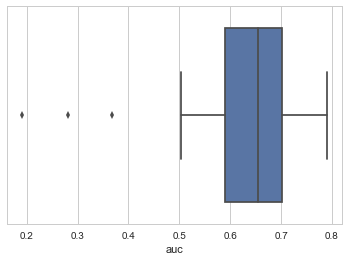

0.6398740165559186


In [262]:
acc_score_df_pdbp_int=resamplemodel(mod_dataPDBP_int,reps=100,model=svc_mod,numgn=mod_dataPDBP_int.shape[1]-3)

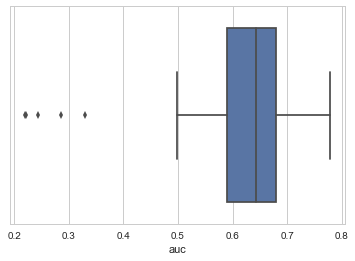

0.6239391134674932


In [223]:
acc_score_df_pdbp=resamplemodel(mod_dataPDBP,reps=100,model=svc_mod,numgn=mod_dataPDBP.shape[1]-3)

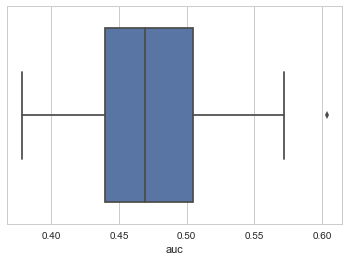

In [156]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=100,model=GaussianNB())

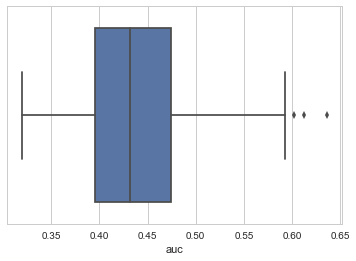

In [158]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=100,model=LogisticRegression(random_state=0, solver='lbfgs'))


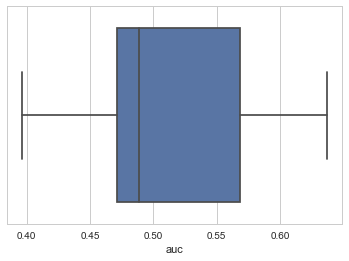

In [162]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=10,model=RandomForestClassifier(max_depth=10, n_estimators=50, max_features=200))


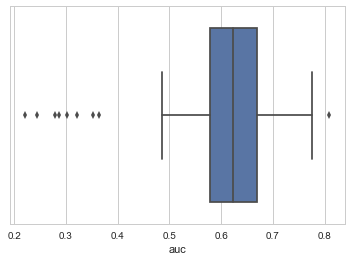

0.6386622447275152


In [166]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=100,model=SVC(kernel="linear", C=0.025,probability=True))

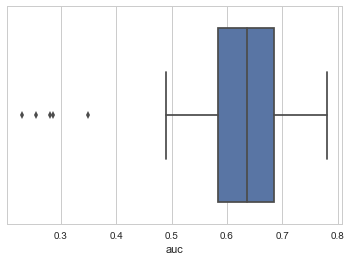

0.6386622447275152


In [168]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=100,model=SVC(kernel="linear", C=1,probability=True))

In [170]:
acc_score_df_pdbp2['auc'].mean()

0.6263597231855266

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)

In [ ]:
acc_score_df_pdbp2=resamplemodel(mod_dataPDBP,reps=100,model=SVC(kernel="linear", C=0.025,probability=True))

In [139]:
classifiers = [BernoulliNB(alpha=0.1),DecisionTreeClassifier(max_depth=4), GaussianProcessClassifier(), LogisticRegression(random_state=0, solver='lbfgs'),KNeighborsClassifier(7), GaussianNB(),
                MLPClassifier(alpha=1, max_iter=1000), QuadraticDiscriminantAnalysis(), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=5),
               SVC(kernel="linear", C=0.025,probability=True),xgb.XGBClassifier(random_state=1,learning_rate=0.01)]#],rf2]    

names = ["Bernoulli NB","Decision Tree", "Gauss Proc","Log Reg","KNN", "Naive Bayes","Neural Net","QDA","Random Forest","Linear SVM",
         "XGBoost"]#],"rf_gs"]

In [141]:
len(names)

11

In [147]:

def resamplemodel2(df,reps=10,ynm="PD"):
    mod_arr=np.asarray([])
    acc_arr=np.asarray([])
    auc_arr=np.asarray([])
    for mod,j in enumerate(classifiers):
        
        for i in range(reps):
                test,accuracy,auc_score=model2(df,mod,"Diagnosis",remcols,yname=ynm)
                mod_arr=np.append(mod_arr,names[j])
                acc_arr=np.append(acc_arr,accuracy)
           
    
    return acc_score_df


In [ ]:
acc_score_df_pdbp=resamplemodel(mod_dataPDBP,reps=100,model=svc_mod)

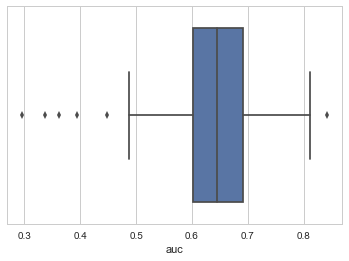

In [150]:


#acc_score_df_pdbp

In [127]:
acc_score_df_pdbp["auc"].mean()

0.6386622447275152

In [102]:
acc_pdbp_xgb

,accuracy,auc
0,0.475410,0.438312
1,0.475410,0.554920
2,0.459016,0.511828
3,0.573770,0.560215
4,0.606557,0.682432


In [103]:
%%time
acc_pdbp_xgb=resamplemodel(mod_dataPDBP,reps=100,model=xgb_gs3)

/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guid

CPU times: user 10min 39s, sys: 7.65 s, total: 10min 47s
Wall time: 2min 58s


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guid

In [108]:
acc_score_df_pdbp["accuracy"].mean()

0.6268852459016393

In [105]:
acc_pdbp_xgb['auc'].mean()

0.5388145929789586

In [ ]:
acc_score_df_pdbp["accuracy"].mean()

In [84]:
acc_score_df_pdbp

,accuracy,auc
0,0.646154,0.702586
1,0.553846,0.614522
2,0.676923,0.721500
3,0.615385,0.680077
4,0.676923,0.740000


In [54]:
acc_score_df_geo=resamplemodel(geodata,reps=5)

(307, 54678)
(131, 54678)


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.6183206106870229
0.6666666666666666
0.6666666666666666


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(307, 54678)
(131, 54678)


KeyboardInterrupt: 

In [ ]:
acc_arr=np.asarray([])
auc_arr=np.asarray([])
for i in range(10):
    test,accuracy,auc_score=model2(geodata,svc_mod,"Diagnosis")
    acc_arr=np.append(acc_arr,accuracy)
    auc_arr=np.append(auc_arr,auc_score)


In [43]:
acc_score_df=pd.DataFrame({"accuracy":acc_arr,"auc":auc_arr})
acc_score_df

,accuracy,auc
0,0.618321,0.716905
1,0.641221,0.737939
2,0.694656,0.764637
3,0.633588,0.705236
4,0.610687,0.708022
5,0.633588,0.716884
6,0.648855,0.709836
7,0.564885,0.667371
8,0.625954,0.701959
9,0.664122,0.747535


In [294]:
%%time
PPMImod_fin=pd.read_csv('%s%s' % (path,'PPMImod_fin.csv'))

CPU times: user 7min 26s, sys: 10.8 s, total: 7min 37s
Wall time: 7min 48s


In [295]:
PPMImod_fin['Diagnosis'].value_counts()

PD    816
HC    711
Name: Diagnosis, dtype: int64

In [296]:
data_mod=rebalance(PPMImod_fin,"Diagnosis","PD","HC")
data_mod['Diagnosis'].value_counts()

PD    711
HC    711
Name: Diagnosis, dtype: int64

In [297]:
PPMImod_fin['RECRUITMENT_CAT'].value_counts()

PD          458
GENUN       238
REGUN       225
HC          191
GENPD       183
REGPD       175
PRODROMA     57
Name: RECRUITMENT_CAT, dtype: int64

In [299]:
%%time
data_mod=rebalance(PPMImod_fin[(PPMImod_fin['RECRUITMENT_CAT']=="GENPD")|
                              (PPMImod_fin['RECRUITMENT_CAT']=="PD")],"RECRUITMENT_CAT","GENPD","PD")
test,accuracy,auc_score=model(data_mod,svc_mod,"RECRUITMENT_CAT")

[[5.24422e+01 1.59944e+02 2.75791e+01 ... 2.67113e-01 2.10495e-01
  0.00000e+00]
 [3.97988e+01 1.85893e+02 2.05087e+01 ... 3.47669e-01 4.62616e-01
  0.00000e+00]
 [5.97607e+01 2.38207e+02 2.84150e+01 ... 0.00000e+00 9.81199e-01
  0.00000e+00]
 ...
 [9.41698e+01 1.60975e+02 2.80484e+01 ... 1.88204e-01 1.04499e+00
  6.68140e-02]
 [5.24373e+01 1.72183e+02 2.20185e+01 ... 3.46712e-01 3.40937e-01
  0.00000e+00]
 [7.92305e+01 1.73313e+02 4.40691e+01 ... 3.72738e-01 9.19837e-01
  0.00000e+00]]
0.8272727272727273
CPU times: user 32 s, sys: 1.4 s, total: 33.4 s
Wall time: 34.2 s


In [301]:
%%time
data_mod=rebalance(PPMImod_fin[(PPMImod_fin['RECRUITMENT_CAT']=="HC")|
                              (PPMImod_fin['RECRUITMENT_CAT']=="PD")],"RECRUITMENT_CAT","PD","HC")
test,accuracy,auc_score=model(data_mod,svc_mod,"RECRUITMENT_CAT")

[[4.49543e+01 1.42745e+02 1.66078e+01 ... 5.27725e-01 1.33585e-01
  0.00000e+00]
 [5.21450e+01 1.49917e+02 2.83511e+01 ... 1.22182e-01 2.44505e-01
  2.58058e-02]
 [4.83584e+01 1.49616e+02 2.05333e+01 ... 0.00000e+00 1.82356e-01
  0.00000e+00]
 ...
 [5.38191e+01 1.39131e+02 1.74873e+01 ... 1.73623e-01 3.12146e-01
  2.62002e-01]
 [4.46090e+01 1.66804e+02 2.28534e+01 ... 3.14204e-01 0.00000e+00
  0.00000e+00]
 [9.87978e+01 1.67417e+02 3.36205e+01 ... 0.00000e+00 3.55055e-01
  9.11361e-02]]
0.5739130434782609
CPU times: user 49.8 s, sys: 1.31 s, total: 51.1 s
Wall time: 51.8 s


In [302]:
data_mod['RECRUITMENT_CAT'].value_counts()

PD    191
HC    191
Name: RECRUITMENT_CAT, dtype: int64

In [303]:
data_mod.columns

Index(['Unnamed: 0',
       '('ENST00000000233.5|ENSG00000004059.6|OTTHUMG00000023246.5|OTTHUMT00000059567.2|ARF5-001|ARF5|1103|UTR5:1-154|CDS:155-697|UTR3:698-1103|',)',
       '('ENST00000000412.3|ENSG00000003056.3|OTTHUMG00000168276.1|OTTHUMT00000399130.1|M6PR-001|M6PR|2756|UTR5:1-469|CDS:470-1303|UTR3:1304-2756|',)',
       '('ENST00000000442.6|ENSG00000173153.9|OTTHUMG00000150641.4|OTTHUMT00000319303.1|ESRRA-002|ESRRA|2215|UTR5:1-171|CDS:172-1443|UTR3:1444-2215|',)',
       '('ENST00000001008.4|ENSG00000004478.5|OTTHUMG00000090429.2|OTTHUMT00000206861.1|FKBP4-001|FKBP4|2267|UTR5:1-187|CDS:188-1567|UTR3:1568-2267|',)',
       '('ENST00000001146.2|ENSG00000003137.4|OTTHUMG00000129756.4|OTTHUMT00000251969.1|CYP26B1-001|CYP26B1|4732|UTR5:1-204|CDS:205-1743|UTR3:1744-4732|',)',
       '('ENST00000002125.4|ENSG00000003509.11|OTTHUMG00000128468.5|OTTHUMT00000250267.1|NDUFAF7-001|NDUFAF7|2176|UTR5:1-40|CDS:41-1366|UTR3:1367-2176|',)',
       '('ENST00000002165.6|ENSG00000001036.9|OTTHUMG0

In [20]:
data_mod.shape
X=np.asarray(data_mod.drop(['Unnamed: 0','Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
y=np.asarray(data_mod["Diagnosis"])

train,test=train_test(data_mod,'Sample',0.7)

X_train=np.asarray(train.drop(["Unnamed: 0",'Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
y_train=np.asarray(train["Diagnosis"])

X_test=np.asarray(test.drop(["Unnamed: 0",'Sample','Diagnosis','RECRUITMENT_CAT'],axis=1))
y_test=np.asarray(test["Diagnosis"])

(267, 95313)
(115, 95313)


In [16]:
X_train.shape

(267, 95309)

Develop a 3D array for autoencoder and neural networks

In [10]:
from keras.layers import Input, Dense
from keras.models import Model


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/michaelallwright/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv3D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling3D(pool_size=(3, 3,1))(conv1) #14 x 14 x 32
    conv2 = Conv3D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling3D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv3D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv3D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling3D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv3D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling3D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv3D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(95309,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(95309, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [18]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [22]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=2000,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 267 samples, validate on 115 samples
Epoch 1/50
267/267 [==============================] - 4s 16ms/step - loss: -154.1885 - val_loss: -154.2953
Epoch 2/50
267/267 [==============================] - 3s 11ms/step - loss: -154.1886 - val_loss: -154.2951
Epoch 3/50
267/267 [==============================] - 3s 12ms/step - loss: -154.1886 - val_loss: -154.2952
Epoch 4/50
267/267 [==============================] - 4s 13ms/step - loss: -154.1885 - val_loss: -154.2950
Epoch 5/50
267/267 [==============================] - 4s 13ms/step - loss: -154.1884 - val_loss: -154.2951
Epoch 6/50
267/267 [==============================] - 4s 14ms/step - loss: -154.1885 - val_loss: -154.2952
Epoch 7/50
267/267 [==============================] - 4s 13ms/step - loss: -154.1886 - val_loss: -154.2949
Epoch 8/50
267/267 [==============================] - 4s 14ms/step - loss: -154.1883 - val_loss: -154.2951
Epoch 9/50
267/267 [==============================] - 4s 14ms/step - loss: -154.1885 - val_loss: -

In [ ]:
data_modchk=data_mod.drop(['Sample','Diagnosis','RECRUITMENT_CAT'],axis=1)

In [7]:
train,test=train_test(data_mod,'Sample',0.7)

(995, 95313)
(427, 95313)


In [ ]:
def reshapedata(df):
    df=df.drop(['Sample','Diagnosis','RECRUITMENT_CAT'],axis=1)
    for i in range(df.shape[0]):
        x1=np.asarray(df.iloc[i:i+1, : 94554])
        x1=x1.reshape(1,102,103,9)
        if i==0:
            x_full=x1
        else:
            x_full=np.vstack((x_full,x1))
    return x_full

In [ ]:
arr_train=reshapedata(train)
arr_test=reshapedata(test)

In [ ]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)


Convolutional neural network

In [117]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py

/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/michaelallwright/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [128]:
import tensorflow as tf
print("Data Loading")
mnist = tf.keras.datasets.mnist
(train_x, train_y),(test_x, test_y) = mnist.load_data()
train_x, test_x = train_x / 255.0, test_x / 255.0

total_train_data = len(train_y)
total_test_data = len(test_y)

print("Encoding Labels")
# One-Hot encode the labels
train_y = encodeLabels(train_y)
test_y = encodeLabels(test_y)

Data Loading
Encoding Labels


NameError: name 'encodeLabels' is not defined

In [121]:
sample_shape=(102,103,9)

In [127]:
input_shape =(4, 102,103,9, 1)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv3D(
2, 3, activation='relu', input_shape=input_shape)(x)
print(y.shape)


TypeError: 'module' object is not callable

In [122]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))


ValueError: Input 0 is incompatible with layer conv3d_1: expected ndim=5, found ndim=4

In [ ]:

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3)

In [12]:
test,accuracy,auc_score=model(data_mod,xgb_gs3,"Diagnosis")

(995, 95313)


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(427, 95313)
0.6533957845433255
0.6983545414655551


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:

print(PPMImod_fin['RECRUITMENT_CAT'].value_counts())

print("Running models on reduced data")
test,accuracy,auc_score=model(data_mod,xgb_gs3,"Diagnosis")
test,accuracy,auc_score=model(data_mod,svc_mod,"Diagnosis")
print("Running models on full data")


In [7]:
test,accuracy,auc_score=model(PPMImod_fin,svc_mod,"RECRUITMENT_CAT")

(1069, 95313)
(458, 95313)
0.46943231441048033


/Users/michaelallwright/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1]:
import pandas as pd
import numpy as np

In [3]:
mod_data=pd.read_csv("/Users/michaelallwright//Dropbox (Sydney Uni)/michael_PhD/Projects/PPMI/Data/Abundance/model_data.csv")

In [4]:
mod_data.shape

(1527, 1)